# Progressive Learning on Audio Task


## Next Steps:
1. simplify the codes

Method:

"Starting Task {task_ii} For Fold {shift} For Slot {slot}"

cross_val_data:

LF_experiment:

Parameters:
data_x
data_y
ntrees

shift_fold = range(1,7,1)
shift = 1,2,3,4,5,6
n_splits = 6: six kinds of train and test division

slot
model
num_points_per task
total_task = 10
acorn

## Import Modules

In [2]:
import os #read path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

import tensorflow as tf
import tensorflow_datasets as tfds

from joblib import Parallel, delayed #computing efficiency
from itertools import product #form iterable

import librosa #process audio
import librosa.display

## Load Spoken_Digit

In [3]:
file = os.listdir('D:/Python Exploration/free-spoken-digit-dataset/recordings')

data=[]
for i in file:
    x , sr = librosa.load('D:/Python Exploration/free-spoken-digit-dataset/recordings/'+i, sr = 8000)
    data.append(x)

In [4]:
sr

8000

In [5]:
# notice the difference in audio length (time)
print(len(data))
print(data[0].shape)
print(data[1].shape)

3000
(2384,)
(4727,)


In [6]:
# play the audio (NO.3000 audio, number 9)
import IPython.display as ipd

num = 828
print('Length of the audio: ',data[num].shape[0],'digits') # 8kHz, so 1s = 8000digits
ipd.Audio(data[num], rate=sr)

Length of the audio:  1288 digits


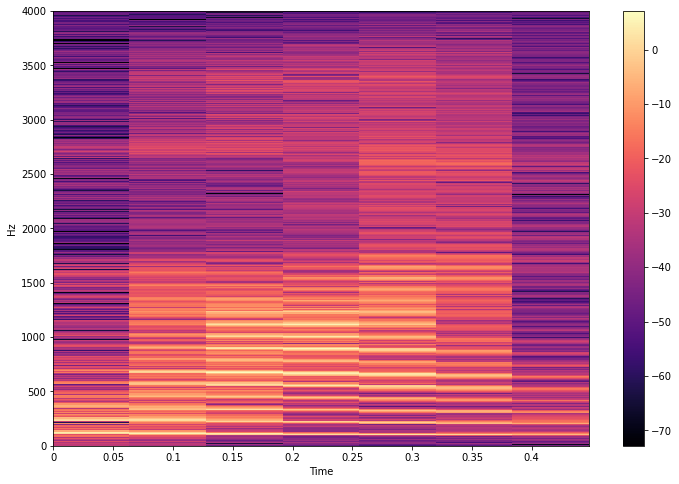

In [7]:
# example STFT plot (NO.3000 audio, number 9)

%matplotlib inline

X = librosa.stft(data[2999])
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(12, 8))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz') 
plt.colorbar()

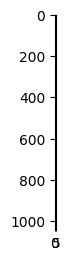

In [8]:
#Xdb
#a = np.random.random((16, 16))
plt.figure(figsize=(2.8, 2.8),dpi = 100)
plt.imshow(Xdb, cmap='hot', interpolation='nearest')
plt.show()

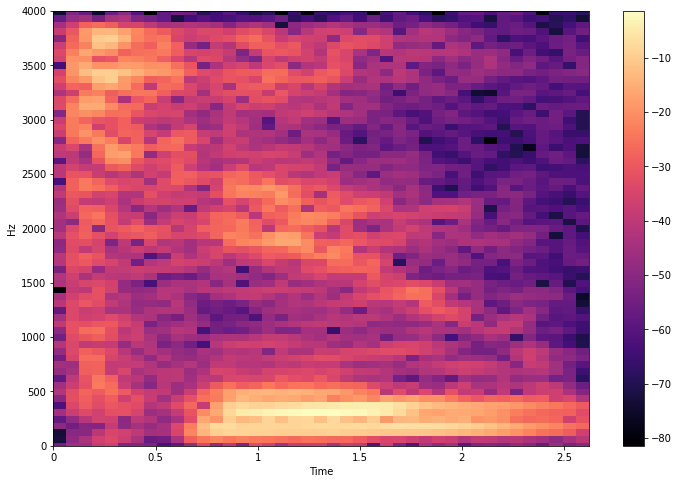

In [9]:
# example STFT plot (The shortest audio)

%matplotlib inline

X = librosa.stft(data[828],n_fft = 128)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(12, 8))
librosa.display.specshow(Xdb[:], sr=sr, x_axis='time', y_axis='hz') 
plt.colorbar()

In [22]:
Xdb.shape


(65, 41)

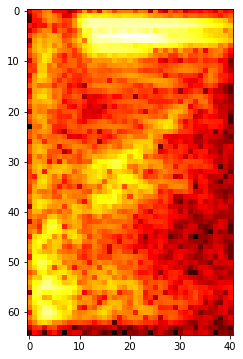

In [10]:
plt.figure(figsize=(6, 6))
plt.imshow(Xdb, cmap='hot', interpolation='nearest')
plt.show()

In [11]:
import cv2

In [12]:
Xdb_after = cv2.resize(Xdb, (28, 28))

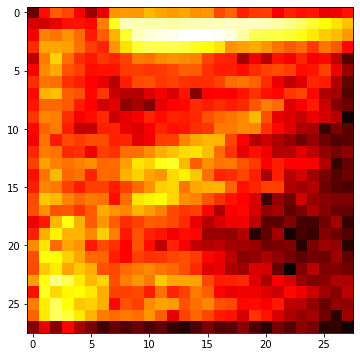

In [13]:
plt.figure(figsize=(6, 6))
plt.imshow(Xdb_after, cmap='hot', interpolation='nearest')
plt.show()

In [16]:
from PIL import Image

img_before = Image.fromarray(Xdb)

img_28 = img.resize((28,28), Image.ANTIALIAS)

Xdb_after = np.array(img_28)

NameError: name 'img' is not defined

In [ ]:
plt.figure(figsize=(1, 1))
plt.imshow(Xdb_after, cmap='hot', interpolation='nearest')
plt.show()

In [ ]:
a = np.asarray(img)
plt.figure(figsize=(8, 8))
plt.imshow(a, cmap='hot', interpolation='nearest')
plt.show()

## Data Preparation
- Method 1: Compute the mean of each row (frequency), and get 1025*1 array for each audio.
- Method 2: Perform pooling on the spectrum and get 28*28 array for each audio.

### Method 1

In [ ]:
# Data Prepatration -X
# 1 * 1025

X=[]
for i in range(len(data)):
    X.append(abs(librosa.stft(data[i]).mean(axis = 1).T))
X1= np.array(X)
#X1.shape #(3000, 1025)

# Data Prepatration -Y
# 

y = [i[0] for i in file]
Y1 = pd.get_dummies(y) #One Hot Encoding
#Y1 (3000,10)

In [ ]:
X1.shape

In [ ]:
Y1 = np.array([i[0] for i in file]).astype(int).reshape(3000,1)
Y1.shape

In [ ]:
data_y=np.array([i[0] for i in file]).astype(int)
data_y

In [ ]:
# find the longest/shortest audio
min = librosa.stft(data[0]).shape[1]
max = librosa.stft(data[0]).shape[1]

for i in range(len(data)):
    if librosa.stft(data[i]).shape[1] > max: 
        max = librosa.stft(data[i]).shape[1]
        n_max=i
    if librosa.stft(data[i]).shape[1] < min: 
        min = librosa.stft(data[i]).shape[1]
        n_min=i
    #print(librosa.stft(data[i]).shape[1])
print(max,min)
print(n_max,n_min)

In [ ]:
X1.shape

In [ ]:
Y1.shape

In [ ]:
Y1[0:1500,:].shape

# ProgLearn Attempt 1104

problems:
1. crossvalidation not used


In [ ]:
import os #read path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import tensorflow as tf
import tensorflow_datasets as tfds
from joblib import Parallel, delayed #computing efficiency
from itertools import product #form iterable
import librosa #process audio
import librosa.display

#################################################
#%%
import warnings

warnings.simplefilter("ignore")
import random
import tensorflow as tf
from itertools import product

import pickle

from math import log2, ceil

from proglearn.progressive_learner import ProgressiveLearner
from proglearn.deciders import SimpleArgmaxAverage
from proglearn.transformers import (
    TreeClassificationTransformer,
    NeuralClassificationTransformer,
)
from proglearn.voters import TreeClassificationVoter, KNNClassificationVoter

from multiprocessing import Pool
import time

In [ ]:
file = os.listdir('D:/Python Exploration/free-spoken-digit-dataset/recordings')

data=[]
for i in file:
    x , sr = librosa.load('D:/Python Exploration/free-spoken-digit-dataset/recordings/'+i)
    data.append(x)

X=[]
for i in range(len(data)):
    X.append(abs(librosa.stft(data[i]).mean(axis = 1).T))
X_all = np.array(X)

Y_all = np.array([i[0] for i in file]).astype(int).reshape(3000,1)

X_task1 = X_all[0:1500,:]
Y_task1 = Y_all[0:1500,:]

X_task2 = X_all[1500:3000,:]
Y_task2 = Y_all[1500:3000,:]

In [ ]:
Y_task1.shape

In [ ]:
np.where(Y_task1 == 0)[0]

In [ ]:
df = pd.DataFrame()
#shifts = []
#slots = []
accuracies_across_tasks = []
train_times_across_tasks = []
inference_times_across_tasks = []

#Task1
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_task1, Y_task1, test_size=0.25)

default_transformer_class = TreeClassificationTransformer
default_transformer_kwargs = {"kwargs": {"max_depth": 30}}
default_voter_class = TreeClassificationVoter
default_voter_kwargs = {}
default_decider_class = SimpleArgmaxAverage

progressive_learner = ProgressiveLearner(
    default_transformer_class=default_transformer_class,
    default_transformer_kwargs=default_transformer_kwargs,
    default_voter_class=default_voter_class,
    default_voter_kwargs=default_voter_kwargs,
    default_decider_class=default_decider_class,
)
train_start_time = time.time()
progressive_learner.add_task(
    X=X_train1,
    y=y_train1,
    num_transformers=20, ###ntree
    transformer_voter_decider_split=[0.67, 0.33, 0],
    decider_kwargs={"classes": np.unique(y_train1)},
)

train_end_time = time.time()

inference_start_time = time.time()
task_0_predictions = progressive_learner.predict(X_test1, task_id=0)
inference_end_time = time.time()

accuracies_across_tasks.append(np.mean(task_0_predictions == y_test1))
train_times_across_tasks.append(train_end_time - train_start_time)
inference_times_across_tasks.append(inference_end_time - inference_start_time)

print('Task1 finished, accuracy: ',accuracies_across_tasks)

In [ ]:
#Task2
train_start_time = time.time()
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_task2, Y_task2, test_size=0.25)
progressive_learner.add_transformer(
    X=X_train2,
    y=y_train2,
    transformer_data_proportion=1,
    num_transformers=20,
    backward_task_ids=[0],
)
train_end_time = time.time()

inference_start_time = time.time()
task_0_predictions = progressive_learner.predict(X_test1, task_id=0)
inference_end_time = time.time()

accuracies_across_tasks.append(np.mean(task_0_predictions == y_test1))
train_times_across_tasks.append(train_end_time - train_start_time)
inference_times_across_tasks.append(inference_end_time - inference_start_time)

In [ ]:
df["accuracy"] = accuracies_across_tasks
df["train_times"] = train_times_across_tasks
df["inference_times"] = inference_times_across_tasks

err = 1-df['accuracy']
bte = err[0]/err
bte

# Task by six speakers
The codes are stupid now.
I will simply them later!

In [ ]:
file = os.listdir('D:/Python Exploration/free-spoken-digit-dataset/recordings')

data=[]
for i in file:
    x , sr = librosa.load('D:/Python Exploration/free-spoken-digit-dataset/recordings/'+i)
    data.append(x)

X=[]
for i in range(len(data)):
    X.append(abs(librosa.stft(data[i]).mean(axis = 1).T))
X_all = np.array(X)

Y_all_filename = np.array([i[2] for i in file]).reshape(3000,1)
Y_all = np.array([i[0] for i in file]).astype(int).reshape(3000,1)

In [ ]:
first_speaker = ['g','j','l','n','t','y']

In [ ]:
np.where(Y_all_filenamefirst == first_speaker[5])[0]

In [ ]:
index = np.where(Y_all_filenamefirst == first_speaker[0])[0]
X_0 = X_all[index]
Y_0 = Y_all[index]

index = np.where(Y_all_filenamefirst == first_speaker[1])[0]
X_1 = X_all[index]
Y_1 = Y_all[index]

index = np.where(Y_all_filenamefirst == first_speaker[2])[0]
X_2 = X_all[index]
Y_2 = Y_all[index]

index = np.where(Y_all_filenamefirst == first_speaker[3])[0]
X_3 = X_all[index]
Y_3 = Y_all[index]

index = np.where(Y_all_filenamefirst == first_speaker[4])[0]
X_4 = X_all[index]
Y_4 = Y_all[index]

index = np.where(Y_all_filenamefirst == first_speaker[5])[0]
X_5 = X_all[index]
Y_5 = Y_all[index]

In [ ]:
X_0 == X_1

In [ ]:
#Task1 speaker1

df = pd.DataFrame()
accuracies_across_tasks = []
train_times_across_tasks = []
inference_times_across_tasks = []

#Task1
X_train0, X_test0, y_train0, y_test0 = train_test_split(X_0, Y_0, test_size=0.25)

default_transformer_class = TreeClassificationTransformer
default_transformer_kwargs = {"kwargs": {"max_depth": 30}}
default_voter_class = TreeClassificationVoter
default_voter_kwargs = {}
default_decider_class = SimpleArgmaxAverage

progressive_learner = ProgressiveLearner(
    default_transformer_class=default_transformer_class,
    default_transformer_kwargs=default_transformer_kwargs,
    default_voter_class=default_voter_class,
    default_voter_kwargs=default_voter_kwargs,
    default_decider_class=default_decider_class,
)
train_start_time = time.time()
progressive_learner.add_task(
    X=X_train0,
    y=y_train0,
    num_transformers=20, ###ntree
    transformer_voter_decider_split=[0.67, 0.33, 0],
    decider_kwargs={"classes": np.unique(y_train0)},
)

train_end_time = time.time()

inference_start_time = time.time()
task_0_predictions = progressive_learner.predict(X_test0, task_id=0)
inference_end_time = time.time()

accuracies_across_tasks.append(np.mean(task_0_predictions == y_test0))
train_times_across_tasks.append(train_end_time - train_start_time)
inference_times_across_tasks.append(inference_end_time - inference_start_time)

print('Task1 finished, accuracy: ',accuracies_across_tasks)


In [ ]:
#Task2
train_start_time = time.time()
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_1, Y_1, test_size=0.25)
progressive_learner.add_transformer(
    X=X_train1,
    y=y_train1,
    transformer_data_proportion=1,
    num_transformers=20,
    backward_task_ids=[0],
)
train_end_time = time.time()

inference_start_time = time.time()
task_0_predictions = progressive_learner.predict(X_test0, task_id=0)
inference_end_time = time.time()

accuracies_across_tasks.append(np.mean(task_0_predictions == y_test0))
train_times_across_tasks.append(train_end_time - train_start_time)
inference_times_across_tasks.append(inference_end_time - inference_start_time)

In [ ]:
#Task3
train_start_time = time.time()
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_2, Y_2, test_size=0.25)
progressive_learner.add_transformer(
    X=X_train2,
    y=y_train2,
    transformer_data_proportion=1,
    num_transformers=20,
    backward_task_ids=[0],
)
train_end_time = time.time()

inference_start_time = time.time()
task_0_predictions = progressive_learner.predict(X_test0, task_id=0)
inference_end_time = time.time()

accuracies_across_tasks.append(np.mean(task_0_predictions == y_test0))
train_times_across_tasks.append(train_end_time - train_start_time)
inference_times_across_tasks.append(inference_end_time - inference_start_time)

In [ ]:
#Task4
train_start_time = time.time()
X_train3, X_test3, y_train3, y_test3 = train_test_split(X_3, Y_3, test_size=0.25)
progressive_learner.add_transformer(
    X=X_train3,
    y=y_train3,
    transformer_data_proportion=1,
    num_transformers=20,
    backward_task_ids=[0],
)
train_end_time = time.time()

inference_start_time = time.time()
task_0_predictions = progressive_learner.predict(X_test0, task_id=0)
inference_end_time = time.time()

accuracies_across_tasks.append(np.mean(task_0_predictions == y_test0))
train_times_across_tasks.append(train_end_time - train_start_time)
inference_times_across_tasks.append(inference_end_time - inference_start_time)

In [ ]:
#Task5
train_start_time = time.time()
X_train4, X_test4, y_train4, y_test4 = train_test_split(X_4, Y_4, test_size=0.25)
progressive_learner.add_transformer(
    X=X_train4,
    y=y_train4,
    transformer_data_proportion=1,
    num_transformers=20,
    backward_task_ids=[0],
)
train_end_time = time.time()

inference_start_time = time.time()
task_0_predictions = progressive_learner.predict(X_test0, task_id=0)
inference_end_time = time.time()

accuracies_across_tasks.append(np.mean(task_0_predictions == y_test0))
train_times_across_tasks.append(train_end_time - train_start_time)
inference_times_across_tasks.append(inference_end_time - inference_start_time)

In [ ]:
#Task6
train_start_time = time.time()
X_train5, X_test5, y_train5, y_test5 = train_test_split(X_5, Y_5, test_size=0.25)
progressive_learner.add_transformer(
    X=X_train5,
    y=y_train5,
    transformer_data_proportion=1,
    num_transformers=20,
    backward_task_ids=[0],
)
train_end_time = time.time()

inference_start_time = time.time()
task_0_predictions = progressive_learner.predict(X_test0, task_id=0)
inference_end_time = time.time()

accuracies_across_tasks.append(np.mean(task_0_predictions == y_test0))
train_times_across_tasks.append(train_end_time - train_start_time)
inference_times_across_tasks.append(inference_end_time - inference_start_time)

In [ ]:
df["accuracy"] = accuracies_across_tasks
df["train_times"] = train_times_across_tasks
df["inference_times"] = inference_times_across_tasks

err = 1-df['accuracy']
bte = err[0]/err
bte

In [ ]:
#%%
fontsize = 22
ticksize = 20

ax = plt.subplot(111)

# Hide the right and top spines
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position("left")
ax.xaxis.set_ticks_position("bottom")

# fig.suptitle('ntrees = '+str(ntrees),fontsize=25)
ax.plot(
    range(len(bte)),
    bte,
    c="red",
    linewidth=3,
    linestyle="solid",
    label="L2F",
)

ax.set_xlabel("Number of Tasks Seen", fontsize=fontsize)
ax.set_ylabel("Transfer Efficiency (Task 1)", fontsize=fontsize)
ax.set_yticks([0.99, 1.00, 1.01])
ax.tick_params(labelsize=ticksize)
ax.legend(fontsize=22)


In [ ]:
accuracies_across_tasks

In [ ]:
Y_0.shape

In [ ]:
X_0.shape

In [ ]:
first_speaker[1]

In [ ]:
np.where(

In [ ]:
file

In [ ]:
np.array(file[])

In [ ]:
type(file)

In [ ]:
index_g = np.where(file[2]=='g')

In [ ]:
type(index_g)

In [ ]:
print(index_g)

In [ ]:
accuracies_across_tasks

In [ ]:
X_all.shape

In [ ]:
Y_all.shape

In [ ]:
X_task1 = X_all[0:1500,:]

In [ ]:
X_task1.shape

In [ ]:
Y_task2[1120]

### Method 2

In [ ]:
librosa.stft(data[10]).shape

### Performance of Random Forests

In [ ]:

y=np.array(list(map(int,y)))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)




''''
clf = RandomForestClassifier(n_estimators=100, max_depth=5)
clf = clf.fit(X_train, y_train)
Y_predict = clf.predict(X_test)
accuracy=accuracy_score(Y_predict,y_test)
print('Accuracy_RandomForest: ',accuracy)
''''

In [ ]:
y_train[155]

# Following Tutorial: Label Shuffle Experiment for Progressive Learning

In [ ]:
# Reshape the data for proglearn

data_x = X
data_y = np.array(y) ###########here is the problem

In [ ]:
data_x.shape

In [ ]:
data_y.shape

In [ ]:
num_points_per_task = 300
shifts = 2 
num_slots = int(10)
slot_fold = range(10) 

n_trees=[10] # Number of trees in UF
shift_fold = range(1,shifts,1) # Number of shifts

iterable = product(n_trees,shift_fold,slot_fold)

#for i in iterable: why iterable could only be used for one time???
#    print(i)

In [ ]:
from spoken_digit_functions import run_parallel_exp

df_list = Parallel(n_jobs=1,verbose=1)(
    delayed(run_parallel_exp)(
        data_x, data_y, ntree, num_points_per_task, slot=slot, shift=shift) for ntree,shift,slot in iterable)

In [ ]:
df_list

In [ ]:
btes = calc_bte(df_list, num_slots, shifts)

In [ ]:
plot_bte(btes)

In [ ]:
# debug

'''
total_task=10
shift = 1

x = data_x.copy()
y = data_y.copy()
idx = [np.where(data_y == u)[0] for u in np.unique(data_y)]

batch_per_task = 10
sample_per_class = 30

for task in range(total_task):
    print('task:',task)####
    for batch in range(batch_per_task):
        print('batch:',batch)####
        for class_no in range(task, (task + 1), 1):
            print('class_no:',class_no)####
            indx = np.roll(idx[class_no], (shift - 1) * 10)
            print('indx: ',indx)
            print('shape: ',indx.shape)
            #print(indx[400:410])
            
            if batch == 0 and class_no == 0 and task == 0:
                train_x = x[
                    indx[batch * sample_per_class : (batch + 1) * sample_per_class]
                ]
                test_x = x[
                    indx[
                        batch * total_task : (batch + 1) * total_task
                        
                    ]
                ]
                train_y = np.random.randint(
                    low=0, high=total_task, size=sample_per_class
                )
                test_y = np.random.randint(low=0, high=total_task, size=total_task)
                print('train_x: ',train_x)########
                print(train_x.shape)########
                print('test_x: ',test_x)#########
                print(test_x.shape)#####
                print('train_y',train_y)#####
                print(train_y.shape)#########
            else:
                train_x = np.concatenate(
                    (
                        train_x,
                        x[
                            indx[
                                batch
                                * sample_per_class : (batch + 1)
                                * sample_per_class
                            ]
                        ],
                    ),
                    axis=0,
                )
                test_x = np.concatenate(
                    (
                        test_x,
                        x[
                            indx[
                                batch * total_task: (batch + 1) * total_task
                        
                            ]
                        ],
                    ),
                    axis=0,
                )
                if task == 0:
                    train_y = np.concatenate(
                        (
                            train_y,
                            y[
                                indx[
                                    batch
                                    * sample_per_class : (batch + 1)
                                    * sample_per_class
                                ]
                            ],
                        ),
                        axis=0,
                    )
                    test_y = np.concatenate(
                        (
                            test_y,
                            y[
                                indx[
                                    batch * total_task: (batch + 1) * total_task
                            
                                ]
                            ],
                        ),
                        axis=0,
                    )
                else:
                    train_y = np.concatenate(
                        (
                            train_y,
                            np.random.randint(
                                low=0, high=total_task, size=sample_per_class
                            ),
                        ),
                        axis=0,
                    )
                    test_y = np.concatenate(
                        (
                            test_y,
                            np.random.randint(
                                low=0, high=total_task, size=total_task
                            ),
                        ),
                        axis=0,
                    )
'''

In [ ]:
test_x

# Functions copied from Functions

In [ ]:
from proglearn.forest import LifelongClassificationForest

def run_parallel_exp(data_x, data_y, n_trees, num_points_per_task, slot=0, shift=1):

    train_x, train_y, test_x, test_y = cross_val_data(
        data_x, data_y, num_points_per_task, shift=shift
    )
    df = label_shuffle_experiment(
        train_x,
        train_y,
        test_x,
        test_y,
        n_trees,
        shift,
        slot,
        num_points_per_task,
        acorn=12345,
    )
    return df

def cross_val_data(data_x, data_y, num_points_per_task, shift, total_task=10):
    x = data_x.copy()
    y = data_y.copy()
    idx = [np.where(data_y == u)[0] for u in np.unique(data_y)]

    batch_per_task = 10
    sample_per_class = 30

    for task in range(total_task):
        #print('task:',task)####
        for batch in range(batch_per_task):
            #print('batch:',batch)####
            for class_no in range(task, (task + 1), 1):
                #print('class_no:',class_no)####
                indx = np.roll(idx[class_no], (shift - 1) * 10)
                #print('indx: ',indx)
                #print('shape: ',indx.shape)
                #print(indx[400:410])

                if batch == 0 and class_no == 0 and task == 0:
                    train_x = x[indx[batch * sample_per_class : (batch + 1) * sample_per_class]]                    ]
                    test_x = x[indx[batch * total_task : (batch + 1) * total_task]]
                    train_y = np.random.randint(low=0, high=total_task, size=sample_per_class)
                    test_y = np.random.randint(low=0, high=total_task, size=total_task)
                    #print('train_x: ',train_x)########
                    #print(train_x.shape)########
                    #print('test_x: ',test_x)#########
                    #print(test_x.shape)#####
                    #print('train_y',train_y)#####
                    #print(train_y.shape)#########
                else:
                    train_x = np.concatenate(
                        (
                            train_x,
                            x[
                                indx[
                                    batch
                                    * sample_per_class : (batch + 1)
                                    * sample_per_class
                                ]
                            ],
                        ),
                        axis=0,
                    )
                    test_x = np.concatenate(
                        (
                            test_x,
                            x[
                                indx[
                                    batch * total_task: (batch + 1) * total_task

                                ]
                            ],
                        ),
                        axis=0,
                    )
                    if task == 0:
                        train_y = np.concatenate((train_y,y[indx[batch* sample_per_class : (batch + 1)                                * sample_per_class
                                    ]
                                ]#,
                            ),
                            axis=0#,
                        )
                        test_y = np.concatenate(
                            (
                                test_y,
                                y[
                                    indx[
                                        batch * total_task: (batch + 1) * total_task

                                    ]
                                ]#,
                            ),
                            axis=0#,
                        )
                    else:
                        train_y = np.concatenate(
                            (
                                train_y,
                                np.random.randint(
                                    low=0, high=total_task, size=sample_per_class
                                )#,
                            ),
                            axis=0#,
                        )
                        test_y = np.concatenate(
                            (
                                test_y,
                                np.random.randint(
                                    low=0, high=total_task, size=total_task
                                )#,
                            ),
                            axis=0#,
                        )

    return train_x, train_y, test_x, test_y

def label_shuffle_experiment(
    train_x,
    train_y,
    test_x,
    test_y,
    ntrees,
    shift,
    slot,
    num_points_per_task,
    acorn=None,
):

    # We initialize lists to store the results
    df = pd.DataFrame()
    shifts = []
    accuracies_across_tasks = []

    # Declare the progressive learner model (L2F), with ntrees as a parameter
    learner = LifelongClassificationForest(n_estimators=ntrees)

    for task_ii in range(10):
        print("Starting Task {} For Fold {} For Slot {}".format(task_ii, shift, slot))
        if acorn is not None:
            np.random.seed(acorn)

        # If task number is 0, add task. Else, add a transformer for the task
        if task_ii == 0:
            learner.add_task(
                X=train_x[
                    task_ii * 5000
                    + slot * num_points_per_task : task_ii * 5000
                    + (slot + 1) * num_points_per_task
                ],
                y=train_y[
                    task_ii * 5000
                    + slot * num_points_per_task : task_ii * 5000
                    + (slot + 1) * num_points_per_task
                ],
                task_id=0,
            )
        else:
            learner.add_transformer(
                X=train_x[
                    task_ii * 5000
                    + slot * num_points_per_task : task_ii * 5000
                    + (slot + 1) * num_points_per_task
                ],
                y=train_y[
                    task_ii * 5000
                    + slot * num_points_per_task : task_ii * 5000
                    + (slot + 1) * num_points_per_task
                ],
            )

        # Make a prediction on task 0 using the trained learner on test data
        llf_task = learner.predict(test_x[:1000], task_id=0)

        # Calculate the accuracy of the task 0 predictions
        acc = np.mean(llf_task == test_y[:1000])
        accuracies_across_tasks.append(acc)
        shifts.append(shift)

        print("Accuracy Across Tasks: {}".format(accuracies_across_tasks))

    df["data_fold"] = shifts
    df["task"] = range(1, 11)
    df["task_1_accuracy"] = accuracies_across_tasks

    return df


def calc_bte(df_list, slots, shifts):
    shifts = shifts - 1
    reps = slots * shifts
    btes = np.zeros((1, 10), dtype=float)

    bte_tmp = [[] for _ in range(reps)]

    count = 0
    for shift in range(shifts):
        for slot in range(slots):

            # Get the dataframe containing the accuracies for the given shift and slot
            multitask_df = df_list[slot + shift * slots]
            err = []

            for ii in range(10):
                err.extend(
                    1
                    - np.array(
                        multitask_df[multitask_df["task"] == ii + 1]["task_1_accuracy"]
                    )
                )
            # Calculate the bte from task 1 error
            bte = get_bte(err)

            bte_tmp[count].extend(bte)
            count += 1

        # Calculate the mean backwards transfer efficiency
        btes[0] = np.mean(bte_tmp, axis=0)
    return btes


def plot_bte(btes):
    # Initialize the plot and color
    clr = ["#00008B"]
    c = sns.color_palette(clr, n_colors=len(clr))
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))

    # Plot the results
    ax.plot(np.arange(1, 11), btes[0], c=c[0], label="L2F", linewidth=3)

    # Format the plot, and show result
    ax.set_yticks([0.9, 0.95, 1, 1.05, 1.1, 1.15, 1.2])
    ax.set_xticks(np.arange(1, 11))
    ax.tick_params(labelsize=20)
    ax.set_xlabel("Number of tasks seen", fontsize=24)
    ax.set_ylabel("Backward Transfer Efficiency", fontsize=24)
    ax.set_title("Label Shuffled CIFAR", fontsize=24)
    ax.hlines(1, 1, 10, colors="grey", linestyles="dashed", linewidth=1.5)
    right_side = ax.spines["right"]
    right_side.set_visible(False)
    top_side = ax.spines["top"]
    top_side.set_visible(False)
    plt.tight_layout()
    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize=22)
    plt.show()


# trivial code (test first met code)

In [ ]:
n_trees=[10]
shift_fold = range(1,2,1)
slot_fold = range(10)

iterable = product(n_trees,shift_fold,slot_fold)
for i in iterable:
    print(i)

In [ ]:
# Overview of the dataset
# 5 speakers * 10 digit * 50 times = 2500 total number

ds, info = tfds.load('spoken_digit', split='train', with_info=True) #only have split train
tfds.as_dataframe(ds.take(3), info)

In [ ]:
data = []
for sample in ds:
    

In [ ]:
i = 0
for sample in ds:
    #audio = sample['audio']
    print(sample['audio/filename'])
    i += 1
i

In [ ]:
for sample in ds:
    audio = sample['audio']
audio.shape

#test_x = np.array([np.array(sample['audio']) for sample in ds],dtype = float)

In [ ]:
X = np.array([[1,2,3],[2,4,6]])
X[0,2]